In [20]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn import metrics


import warnings
warnings.filterwarnings('ignore')

In [21]:
#importing the data 
df_raw=pd.read_csv("vehicles.csv")
df1=pd.DataFrame(df_raw)


df1=df1[(df1['year']>=2000) & (df1['year']<=2020)]
df1.shape

(397896, 26)

In [22]:
df=df1.drop(columns=['id','url','region','region_url','VIN','image_url','description','size','lat','long','county'])
#they are not useful for analysis
df.dropna(subset=['manufacturer','model','fuel','odometer','transmission','condition', 'cylinders', 'title_status','posting_date', 'drive', 'type', 'paint_color'], axis=0, how='all', inplace=True)
print(df.shape)
df.isnull().sum()

(397896, 15)


price                0
year                 0
manufacturer     12791
model             3678
condition       164527
cylinders       168891
fuel              2640
odometer          4204
title_status      7532
transmission      2402
drive           121071
type             82400
paint_color     120046
state                0
posting_date         0
dtype: int64

In [23]:
#drop duplicates
duplicate = df[df.duplicated()]
duplicate.shape
df2=df.drop_duplicates(keep=False)
df2.shape

(396954, 15)

In [25]:
######################

price                0
year                 0
manufacturer         0
model                0
condition       164347
cylinders            0
fuel                 0
odometer          4204
title_status         0
transmission         0
drive                0
type                 0
paint_color          0
state                0
posting_date         0
dtype: int64

In [26]:
#Add variable 'age' of cars
df2.posting_date = pd.to_datetime(df2.posting_date, utc=True)
df2.posting_date = df2.posting_date.astype('datetime64[ns]')
df2['age'] = df2.posting_date.dt.year.astype(int) - df2.year.astype(int)

In [27]:
#fill null values in odometer column with median values for each value of age
df2['odometer'] = df2.groupby(['age'])['odometer'].apply(lambda x: x.fillna(x.median()))


In [28]:
# Calculate mean odometer values for each condition
mean_odo = df2.groupby('condition')['odometer'].mean()

# Fill missing values in 'condition' column based on 'odometer' values
df2['condition'] = df2.apply(lambda x: 
  'like new' if x['odometer'] <= mean_odo['like new'] else 
  'fair' if x['odometer'] >= mean_odo['fair'] else 
  'excellent' if mean_odo['like new'] < x['odometer'] <= mean_odo['excellent'] else 
  'good' if mean_odo['excellent'] < x['odometer'] <= mean_odo['good'] else 
  'salvage', axis=1).fillna(df2['condition'])

In [ ]:
df2=df2.sort_values(['year','model','condition'])

In [ ]:
df2['transmission'] = df2['transmission'].fillna(method='ffill')
df2['cylinders'] = df2['cylinders'].fillna(method='ffill')
df2['title_status'] = df2['title_status'].fillna(method='ffill')
df2['fuel'] = df2['fuel'].fillna(method='ffill')
df2['paint_color'] = df2['paint_color'].fillna(method='ffill')
df2['drive'] = df2['drive'].fillna(method='ffill')
df2['manufacturer'] = df2['manufacturer'].fillna(method='ffill')
df2['type'] = df2['type'].fillna(method='ffill')
df2['model'] = df2['model'].fillna(method='ffill')
df2.isnull().sum()

In [29]:
df2=df2.dropna()
df2.isnull().sum()

price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
type            0
paint_color     0
state           0
posting_date    0
age             0
dtype: int64

In [30]:
# re-ordering the columns to display price as the last column
df2= df2.reindex(columns=['year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'age','title_status',
       'transmission', 'drive',  'type', 'posting_date','paint_color','state','price'])

In [31]:
#price outliers

print(df2['price'].describe())
# Upper limit and lower limit based on price cars
p1 = df2['price'].quantile(0.99) 
p2 = df2['price'].quantile(0.1)   
print(p1)
print(p2)
df3 = df2[(df2['price'] < p1) & (df2['price'] > p2)]

count    3.969540e+05
mean     4.951579e+04
std      9.399797e+06
min      0.000000e+00
25%      5.997000e+03
50%      1.400000e+04
75%      2.698500e+04
max      3.736929e+09
Name: price, dtype: float64
65000.0
449.0


Text(0.5, 1.0, 'Histogram of Car Prices')

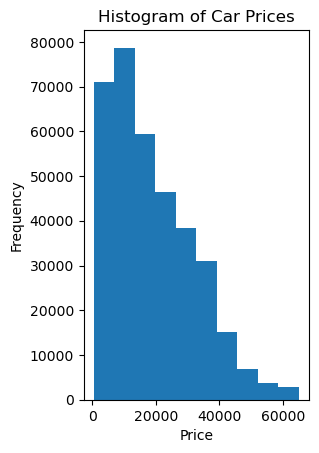

In [32]:
plt.subplot(1,2,1)
plt.hist(df3['price'], bins=10)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Car Prices')

In [33]:
#odometer outliers
# Upper and lower limit based on odometer
o1 = df3['odometer'].quantile(0.99) 
o2 = df3['odometer'].quantile(0.1)  
print(o1)
print(o2)
df4 = df3[(df3['odometer'] < o1) & (df3['odometer'] > o2)]
print(df4['odometer'].describe())

266000.0
16931.0
count    314320.000000
mean     100493.218169
std       55321.036258
min       16935.000000
25%       53048.750000
50%       96474.000000
75%      139596.000000
max      265900.000000
Name: odometer, dtype: float64


In [34]:
#correlation matrix for dataset
corrm=df4.corr()
corrm.style.background_gradient(cmap='coolwarm')

,year,odometer,age,price
year,1.000000,-0.651441,-1.000000,0.593903
odometer,-0.651441,1.000000,0.651441,-0.526753
age,-1.000000,0.651441,1.000000,-0.593903
price,0.593903,-0.526753,-0.593903,1.000000


In [35]:
df5=df4
le=LabelEncoder()
df5['manufacturer']=le.fit_transform(df5['manufacturer'])
df5['model']=le.fit_transform(df5['model'])
df5['condition']=le.fit_transform(df5['condition'])
df5['cylinders']=le.fit_transform(df5['cylinders'])
df5['fuel']=le.fit_transform(df5['fuel'])
df5['title_status']=le.fit_transform(df5['title_status'])
df5['transmission']=le.fit_transform(df5['transmission'])
df5['drive']=le.fit_transform(df5['drive'])
df5['type']=le.fit_transform(df5['type'])
df5['paint_color']=le.fit_transform(df5['paint_color'])
df5['state']=le.fit_transform(df5['state'])

In [36]:
X = df5.drop(columns=['price','posting_date','year']) 
y = df5[['price']] 
X.shape

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.25) 



rf = RandomForestRegressor(n_estimators=20, random_state=0)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf))
print('MAE: ', mean_absolute_error(y_test, y_pred_rf))
print('RMSE: ',rmse_rf)
print('r2_score: ',rf.score(X_test, y_test))
print('MSE: ',metrics.mean_squared_error(y_test, y_pred_rf))


MAE:  2455.7823915654826
RMSE:  4576.216051515686
r2_score:  0.866933485084266
MSE:  20941753.35014981


In [37]:
# Get numerical feature importances
features=X
feature_list = list(features.columns)
features = np.array(features)
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: age                  Importance: 0.37
Variable: odometer             Importance: 0.15
Variable: model                Importance: 0.13
Variable: fuel                 Importance: 0.1
Variable: manufacturer         Importance: 0.06
Variable: drive                Importance: 0.06
Variable: cylinders            Importance: 0.03
Variable: type                 Importance: 0.03
Variable: state                Importance: 0.03
Variable: title_status         Importance: 0.01
Variable: transmission         Importance: 0.01
Variable: paint_color          Importance: 0.01
Variable: condition            Importance: 0.0


[None, None, None, None, None, None, None, None, None, None, None, None, None]